<font size="3">


# Measuring SpO₂ and Pulse Rate Lab

## Introduction

Pulse oximetry is a non-invasive optical technique used to measure the oxygen saturation level (SpO₂) of arterial blood and monitor pulse rate. It plays a critical role in assessing a patient's respiratory and cardiovascular health, both in clinical settings and for personal health monitoring. The method relies on **photoplethysmography (PPG)**, which involves detecting blood volume changes in the microvascular bed of tissue using light absorption characteristics.

In pulse oximetry, a sensor emits **red and infrared (IR) light** through a body part, typically a fingertip or earlobe. The sensor measures the amount of light absorbed by the blood, which varies with the pulsatile changes in arterial blood volume associated with each heartbeat. Oxyhemoglobin and deoxyhemoglobin absorb light differently at red and IR wavelengths, allowing for the estimation of SpO₂ based on the ratio of absorbed red and IR light.

The PPG signal obtained from the sensor consists of two components:

**AC Component**: The pulsatile part of the signal caused by the arterial blood volume changes with each heartbeat. This component is used to determine the **pulse rate**, as the peaks correspond to individual heartbeats.
**DC Component**: The non-pulsatile part due to the constant absorption by tissues, venous blood, and non-pulsatile arterial blood.

By analyzing the AC component of the PPG signal, we can extract the pulse rate by detecting the time intervals between successive peaks. The ratio of the AC to DC components at both red and IR wavelengths is used to calculate SpO₂ using the **ratio-of-ratios method**.

In this notebook, you will work with red and IR waveform data collected using a finger clip sensor. You will apply signal processing techniques to extract meaningful physiological parameters, specifically SpO₂ and pulse rate, from the PPG signals. Through this process, you will gain insights into the principles of photoplethysmography and pulse oximetry, understand how pulse rate is measured from PPG signals.

This notebook demonstrates how to:
 
 - Import and inspect PPG data (red and IR signals)
 - Apply signal processing (band-pass and low-pass filtering) to extract the AC and DC components
 - Detect peaks to extract pulse rate
 - Calculate SpO₂ using the ratio-of-ratios method and sensor calibration
 - Apply moving average filtering to smooth the computed values
 - Compare computed results with reference measurements

**Note:** The data file is assumed to be in the folder: ...\Learn Remote Patient Monitoring\Datasets\SpO2



</font>



<font size="3">

### Step 0: Initialization and Imports

First, we import the necessary libraries and set up our environment.
</font>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# Set matplotlib to display plots inline (for Jupyter)
%matplotlib widget

<font size="3">

### Step 1: Load and Inspect the Data

We will load the SpO₂ data, which contains time-series measurements of red and infrared (IR) signals obtained from the finger clip sensor. These signals are used to compute the oxygen saturation level in the blood and monitor pulse rate.
</font>

In [2]:
# Define the data path and file name
data_folder = r'C:\Users\20181588\Desktop\Learn Remote Patient Monitoring\Datasets\SpO2'
data_file = 'SpO2_data.csv'  # Modify if the file name is different
data_path = os.path.join(data_folder, data_file)

# Read the data using pandas (assumes csv format)
data = pd.read_csv(data_path)

# Display column names and the first few rows
print("Columns in the dataset:")
print(data.columns.tolist())
print("\nFirst few rows of the data:")
print(data.head())

# Extract time and signal data (adjust column names if necessary)
time = data['t [s]'].to_numpy()           # Time in seconds
red_signal = data['Red [bit]'].to_numpy()    # Red sensor data
ir_signal = data['IR [bit]'].to_numpy()      # IR sensor data

Columns in the dataset:
['t [s]', 'Red [bit]', 'IR [bit]']

First few rows of the data:
   t [s]  Red [bit]  IR [bit]
0  0.000      50757     55256
1  0.008      50756     55254
2  0.016      50755     55252
3  0.024      50754     55251
4  0.032      50753     55251


<font size="3">

### Step 2: Signal Preprocessing

The signals obtained from the sensor may contain noise and artifacts due to various factors such as ambient light interference, motion artifacts, and electronic noise. Preprocessing the signals is essential to enhance signal quality and extract meaningful physiological information.

Photoplethysmography (PPG) signals have specific characteristics:

- **Frequency Content** : The fundamental frequency corresponds to the heart rate, typically between 0.8 Hz to 2 Hz (48 bpm to 120 bpm) for adults

- **Noise Sources** : Include motion artifacts, ambient light, and high-frequency electronic noise

To isolate the useful information, we need to apply filtering techniques. Thus, we design a Butterworth band-pass filter to isolate the frequency range associated with the heart rate (approximately 0.8 Hz to 2 Hz).

</font>

In [3]:
# Define the sampling frequency (Hz)
fs = 125

# Define band-pass filter parameters based on expected heart rate (0.8 Hz to 2 Hz)
lowcut = 0.8      # Lower cutoff frequency in Hz
highcut = 2.0     # Upper cutoff frequency in Hz
order = 3         # Filter order

nyq = 0.5 * fs    # Nyquist frequency
low = lowcut / nyq
high = highcut / nyq

# Design the Butterworth band-pass filter
b_bp, a_bp = butter(order, [low, high], btype='band')

# Apply the filter using zero-phase filtering to avoid phase distortion
filtered_red = filtfilt(b_bp, a_bp, red_signal)
filtered_ir = filtfilt(b_bp, a_bp, ir_signal)

<font size="3">

### Step 3: Plotting the Raw and Filtered Signals

Visualizing the signals before and after filtering helps us understand the effect of the preprocessing step.

</font>

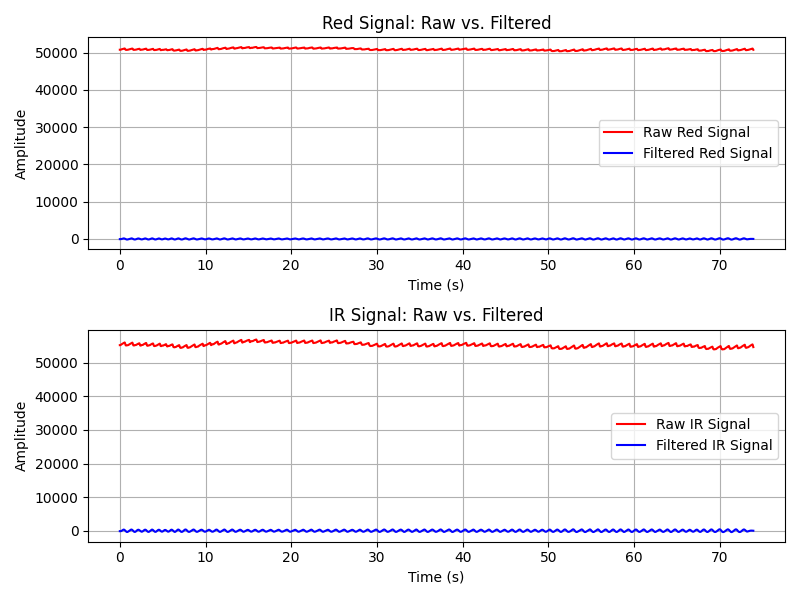

In [4]:
plt.figure(figsize=(8, 6))

# Plot for Red signal
plt.subplot(2, 1, 1)
plt.plot(time, red_signal, 'r', label='Raw Red Signal')
plt.plot(time, filtered_red, 'b', label='Filtered Red Signal')
plt.title('Red Signal: Raw vs. Filtered')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot for IR signal
plt.subplot(2, 1, 2)
plt.plot(time, ir_signal, 'r', label='Raw IR Signal')
plt.plot(time, filtered_ir, 'b', label='Filtered IR Signal')
plt.title('IR Signal: Raw vs. Filtered')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


<font size="3">

#### Expected Observations:

- **Signal Improvement**: The filtered signals should have reduced noise compared to the raw signals
- **Noise Reduction**: Unwanted high-frequency noise and baseline wander should be attenuated
- **Preservation of Information**: The pulsatile nature of the PPG signal should be preserved in the filtered signals
</font>

<font size="3">

### Step 4: Separating AC and DC Components

The PPG signal consists of an AC component and a DC component:

- **AC Component**: Represents the pulsatile changes due to arterial blood volume changes with each heartbeat
- **DC Component**: Represents the non-pulsatile part due to constant absorption from tissues and non-pulsatile blood

Isolating the AC and DC components is crucial for calculating the SpO₂ level and pulse rate. In the steps below, we use a low-pass filter to extract the DC component and subtract it from the raw signal to obtain the AC component.
</font>

In [5]:
# Define a low-pass filter to extract the DC component.
# Here we choose a cutoff frequency lower than the pulsatile component (e.g., 0.5 Hz).
dc_cutoff_freq = 0.5  # Hz
wn_dc = dc_cutoff_freq / nyq  # normalized cutoff
order_dc = 2

b_dc, a_dc = butter(order_dc, wn_dc, btype='low')

# Extract the DC component from the raw signals
dc_red = filtfilt(b_dc, a_dc, red_signal)
dc_ir = filtfilt(b_dc, a_dc, ir_signal)

# Compute the AC components by subtracting the DC components from the raw signals
ac_red = red_signal - dc_red
ac_ir = ir_signal - dc_ir

<font size="3">

### Step 5: Plotting the AC and DC Components

Visualizing the AC and DC components helps us understand their contributions to the overall signal.
</font>

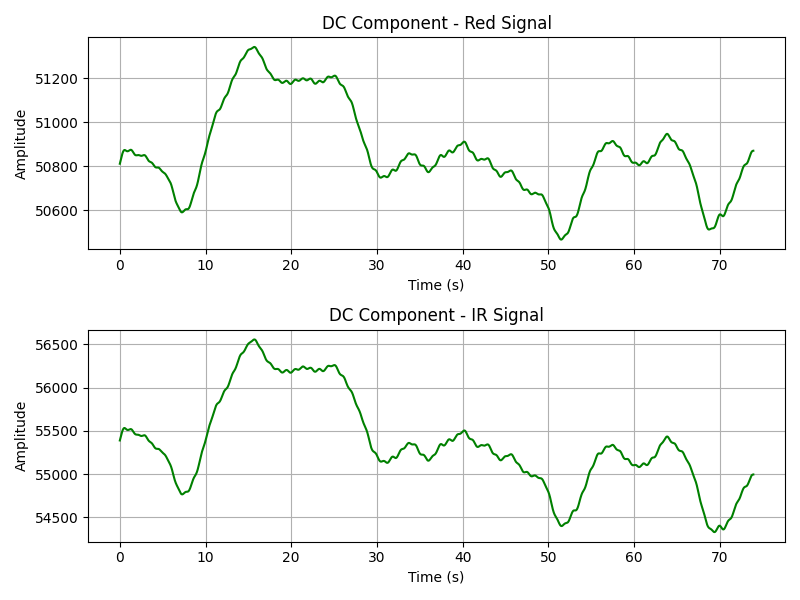

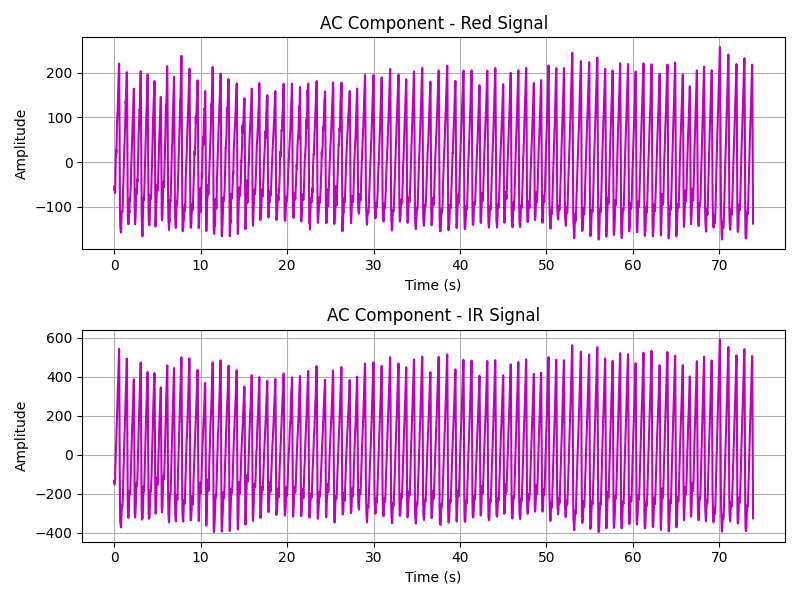

In [6]:
# Plot DC components
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.plot(time, dc_red, 'g')
plt.title('DC Component - Red Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time, dc_ir, 'g')
plt.title('DC Component - IR Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot AC components
plt.figure(figsize=(8, 6))

plt.subplot(2, 1, 1)
plt.plot(time, ac_red, 'm')
plt.title('AC Component - Red Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time, ac_ir, 'm')
plt.title('AC Component - IR Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

<font size="3">

#### Expected Observations:

- **DC Components**: Should appear as steady signals representing baseline absorption
- **AC Components**: Should show pulsatile patterns corresponding to heartbeats
</font>

<font size="3">

### Step 6: Peak Detection for Pulse Rate Extraction

Pulse rate can be extracted by detecting peaks in the AC component of the IR signal. Accurate peak detection is essential for reliable pulse rate calculation.

We use the `find_peaks` function to detect peaks in the filtered IR signal. Adjust the parameters for `min_peak_height` and `min_peak_distance` based on your data.
</font>

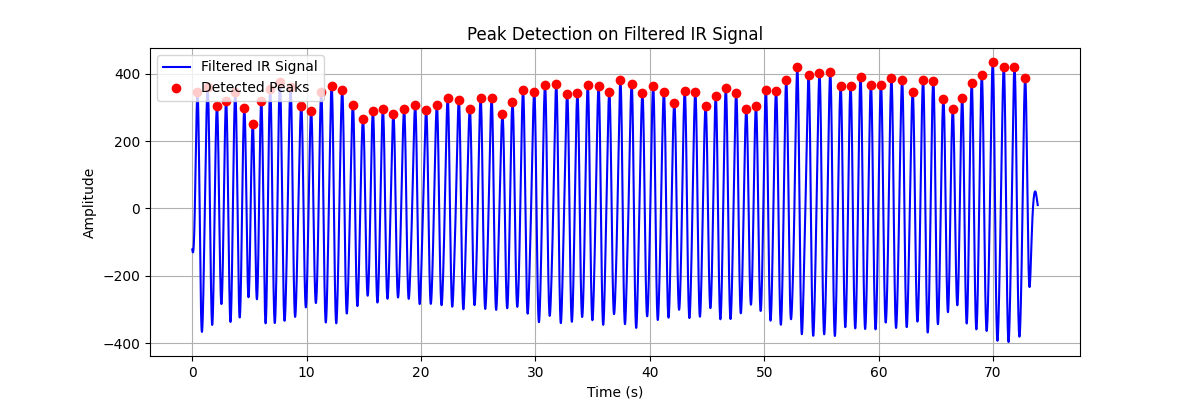

In [7]:
# Set parameters for peak detection.
# For min_peak_distance, we assume that the minimum interval between beats is about 0.5 sec.
min_peak_distance = int(0.5 * fs)

# For min_peak_height, we can set a threshold based on the standard deviation of the filtered IR signal.
min_peak_height = np.std(filtered_ir)

# Detect peaks in the filtered IR signal
peaks_ir, properties = find_peaks(filtered_ir, height=min_peak_height, distance=min_peak_distance)

# Convert peak sample indices to time
peak_times = time[peaks_ir]

# Plot the filtered IR signal with detected peaks
plt.figure(figsize=(12, 4))
plt.plot(time, filtered_ir, 'b', label='Filtered IR Signal')
plt.plot(peak_times, filtered_ir[peaks_ir], 'ro', label='Detected Peaks')
plt.title('Peak Detection on Filtered IR Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

<font size="3">

#### Expected Observations:

- The detected peaks should correspond to individual heartbeats
- Peaks should be evenly spaced if the heart rate is steady
</font>

<font size="3">

### Step 7: Calculating Pulse Rate

By measuring the time intervals between successive heartbeats (peak-to-peak intervals), we can calculate the pulse rate.

In the steps below, we compute the inter-beat intervals (IBI) from the detected peaks and convert these intervals into beats per minute (bpm). A moving average (over 8 beats) is also computed to smooth the data.
</font>

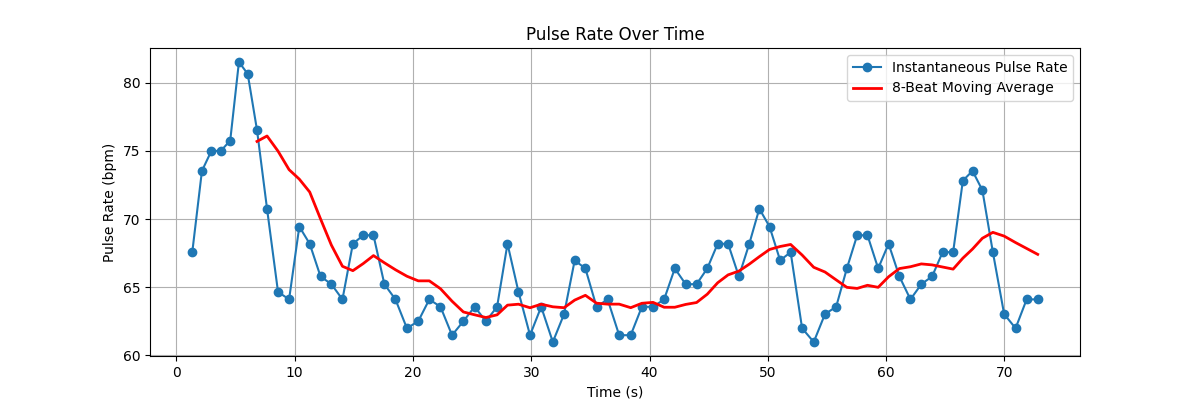

In [8]:
# Calculate inter-beat intervals in seconds
ibi = np.diff(peak_times)  

# Calculate instantaneous pulse rate (bpm)
pulse_rate_instant = 60 / ibi  

# Compute a moving average over 8 beats to smooth the pulse rate
window_size = 8
if len(pulse_rate_instant) >= window_size:
    pulse_rate_moving_avg = np.convolve(pulse_rate_instant, np.ones(window_size)/window_size, mode='valid')
else:
    pulse_rate_moving_avg = pulse_rate_instant  # if not enough beats, use instantaneous values

# Plot the pulse rate over time
plt.figure(figsize=(12, 4))
plt.plot(peak_times[1:], pulse_rate_instant, '-o', label='Instantaneous Pulse Rate')
if len(pulse_rate_instant) >= window_size:
    plt.plot(peak_times[window_size:], pulse_rate_moving_avg, '-r', linewidth=2, label='8-Beat Moving Average')
plt.title('Pulse Rate Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Pulse Rate (bpm)')
plt.legend()
plt.grid(True)
plt.show()

<font size="3">

#### Expected Observations:

- **Variability**: There may be slight variations in the instantaneous pulse rate
- **Smoothing Effect**: The moving average should provide a smoother representation of the pulse rate
</font>



<font size="3">

### Step 8: Computing SpO₂ Levels per Beat

SpO₂ is calculated using the ratio-of-ratios method, which compares the AC and DC components of the red and IR signals. This method is based on the different absorption properties of oxyhemoglobin and deoxyhemoglobin at red and IR wavelengths.

The SpO₂ is calculated using the ratio-of-ratios method:

$ R = \frac{(AC_{red}/DC_{red})}{(AC_{ir}/DC_{ir})} $

The calibration polynomial is then applied:
$ SpO_2 = A \cdot R^2 + B \cdot R + C $

with calibration constants:
 
- A = -2.8668  
- B = -23.155  
- C = 110.27


</font>

Computed R per beat:
[0.4495466417383382, 0.45369616159569154, 0.46510464570759685, 0.49899408246205706, 0.4866294659702238, 0.4901862040893917, 0.4667316455899752, 0.4926267852139992, 0.4649237555382927, 0.5032978575975758, 0.464962172821654, 0.4634752489319632, 0.46595768756532097, 0.46860290720033576, 0.4527501757444929, 0.4540980966741169, 0.45294478688126666, 0.4543966961382015, 0.4506663035678074, 0.4658556690810197, 0.4447679648116917, 0.45320937820870316, 0.46022131420810575, 0.46083077284029833, 0.45829661380932074, 0.475730297201773, 0.4440722339234925, 0.45910291462382113, 0.4446942237231664, 0.4811124729190965, 0.473371750922936, 0.4479783104899325, 0.4465828123067447, 0.44776660742019403, 0.45311397904759493, 0.460511310228146, 0.45613050084829987, 0.45309955247617434, 0.4546835664422419, 0.4572540617794439, 0.4653977345760042, 0.4532573494299286, 0.46352635596413755, 0.4589605501154895, 0.4629094776676367, 0.46649039258316094, 0.4665006923586404, 0.4670675156636621, 0.482

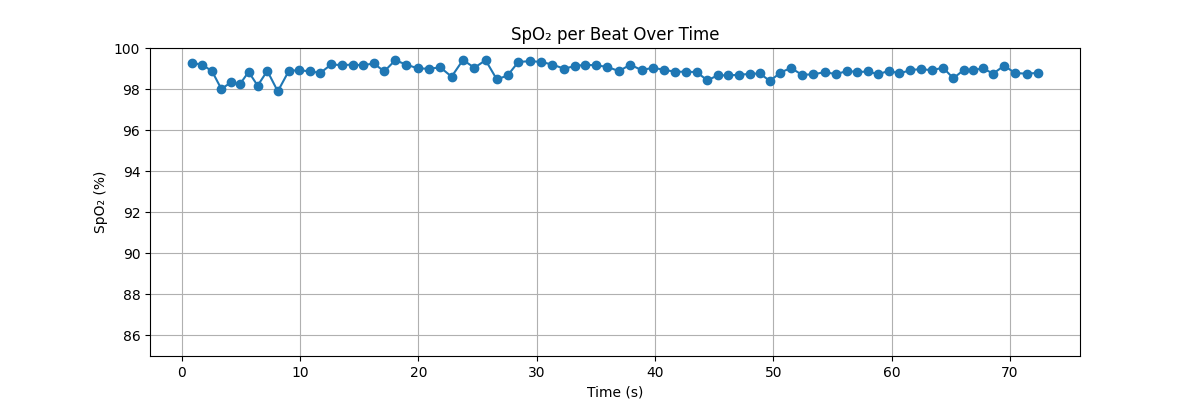

In [9]:
# Calibration constants
A = -2.8668
B = -23.155
C = 110.27

# Initialize lists to store per-beat measurements
AC_red_per_beat = []
AC_ir_per_beat = []
DC_red_per_beat = []
DC_ir_per_beat = []
R_per_beat = []
SpO2_per_beat = []
beat_times = []

# Loop through each beat defined by successive peaks
for i in range(len(peaks_ir) - 1):
    # Define indices for the current beat interval
    idx_start = peaks_ir[i]
    idx_end = peaks_ir[i+1]  # include up to the next peak
    
    # Extract segments for the current beat (using AC and DC from the raw signals)
    # Here we use the AC and DC components computed earlier
    ac_red_beat = ac_red[idx_start:idx_end]
    ac_ir_beat = ac_ir[idx_start:idx_end]
    dc_red_beat = dc_red[idx_start:idx_end]
    dc_ir_beat = dc_ir[idx_start:idx_end]
    
    # Compute the AC amplitude (peak-to-peak) for red and IR channels
    AC_red = np.max(ac_red_beat) - np.min(ac_red_beat)
    AC_ir = np.max(ac_ir_beat) - np.min(ac_ir_beat)
    
    # Compute the DC level (mean value) for red and IR channels
    DC_red = np.mean(dc_red_beat)
    DC_ir = np.mean(dc_ir_beat)
    
    # Avoid division by zero; if DC is too small, skip this beat
    if DC_red == 0 or DC_ir == 0:
        continue

    # Compute ratio R for the current beat
    R = (AC_red / DC_red) / (AC_ir / DC_ir)
    
    # Compute SpO2 for the current beat using the calibration polynomial
    spo2 = A * R**2 + B * R + C
    
    # Record the time of the beat as the midpoint between the two peaks
    beat_time = (time[idx_start] + time[idx_end]) / 2
    
    # Append computed values to lists
    AC_red_per_beat.append(AC_red)
    AC_ir_per_beat.append(AC_ir)
    DC_red_per_beat.append(DC_red)
    DC_ir_per_beat.append(DC_ir)
    R_per_beat.append(R)
    SpO2_per_beat.append(spo2)
    beat_times.append(beat_time)

# Convert lists to numpy arrays for further processing
beat_times = np.array(beat_times)
SpO2_per_beat = np.array(SpO2_per_beat)

# Display computed R and SpO₂ per beat
print("Computed R per beat:")
print(R_per_beat)
print("\nComputed SpO₂ per beat:")
print(SpO2_per_beat)

# Plot SpO₂ per beat over time
plt.figure(figsize=(12, 4))
plt.plot(beat_times, SpO2_per_beat, '-o')
plt.title('SpO₂ per Beat Over Time')
plt.xlabel('Time (s)')
plt.ylabel('SpO₂ (%)')
plt.ylim([85, 100])  # Adjust y-axis limits as needed
plt.grid(True)
plt.show()

<font size="3">

#### Expected Observations:

- A plot of SpO₂ per beat over time, showing the variability in measurements. Typically in the range of 90% to 100% for healthy individuals
</font>



<font size="3">

### Step 9: Moving Average of SpO₂ per Beat

SpO₂ measurements can be affected by noise and physiological variations. Calculating a moving average over multiple beats can provide a more stable estimate. 

We calculate the moving average of the per-beat SpO₂ measurements over moving windows of **1 beat**, **8 beats**, **16 beats**, and **the entire period**, and analyze the effect on measurement stability.
</font>

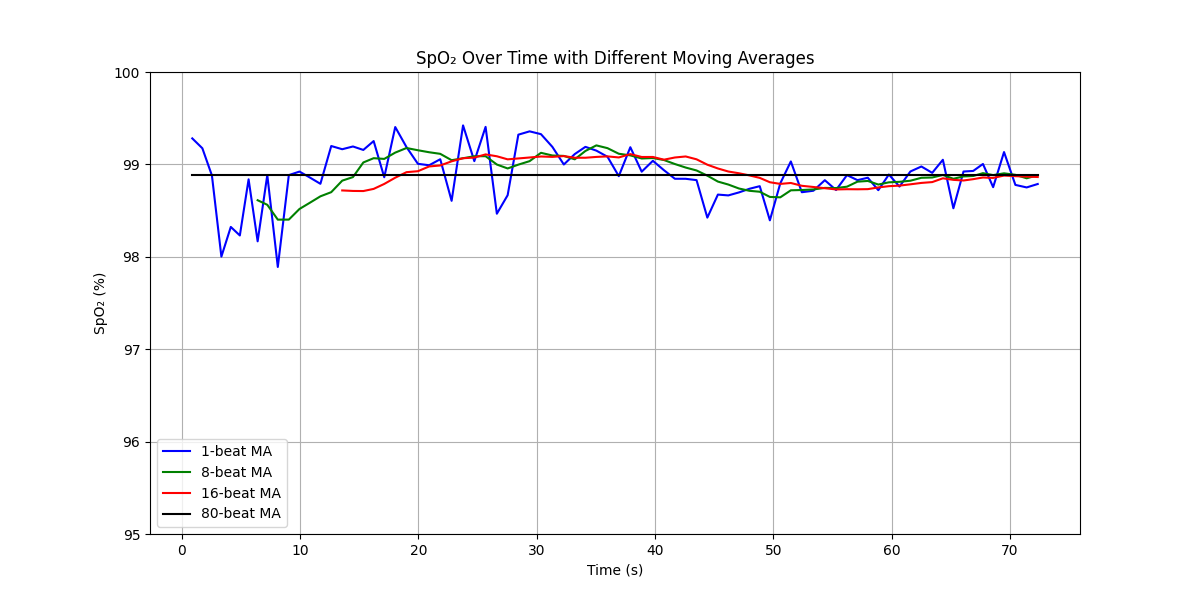

In [10]:
# Define window sizes in beats
window_sizes = [1, 8, 16, len(SpO2_per_beat)]  # 1-beat, 8-beat, 16-beat, and entire period

# Prepare a dictionary to store moving averages for each window size
SpO2_moving_avg = {}

# Use a simple convolution to compute the moving average
for ws in window_sizes:
    if ws > len(SpO2_per_beat):
        SpO2_moving_avg[ws] = SpO2_per_beat
    else:
        SpO2_moving_avg[ws] = np.convolve(SpO2_per_beat, np.ones(ws)/ws, mode='valid')

# Plot SpO₂ over time for different moving average window sizes
plt.figure(figsize=(12, 6))
colors = {1: 'b', 8: 'g', 16: 'r', len(SpO2_per_beat): 'k'}

for ws, ma in SpO2_moving_avg.items():
    # If the moving average array is only a single value, create a constant array for plotting.
    if len(ma) == 1:
        time_axis = beat_times
        y_axis = np.full_like(beat_times, ma[0])
    else:
        time_axis = beat_times[ws-1:]
        y_axis = ma
    plt.plot(time_axis, y_axis, color=colors[ws], linewidth=1.5, label=f'{ws}-beat MA')

plt.title('SpO₂ Over Time with Different Moving Averages')
plt.xlabel('Time (s)')
plt.ylabel('SpO₂ (%)')
plt.legend()
plt.ylim([95, 100])
plt.grid(True)
plt.show()


<font size="3">

#### Expected Observations:

- **1-beat Moving Average**:
    Shows the most variability, reflecting beat-to-beat fluctuations
- **8-beat and 16-beat Moving Averages**:
    Provide increasingly smoother curves, reducing the effect of short-term variations.
- **Entire Period Moving Average**:
    Represents a single average value across the entire dataset, appearing as a straight line.

</font>




<font size="3">

### Step 10: Comparing with Reference Measurements

Finally, we compare our computed pulse rate and SpO₂ values with the reference measurements.

**Note:** Replace the placeholder reference values with your actual measured values.
</font>

In [11]:
# Calculate the average computed pulse rate (using instantaneous values) and average SpO₂ (using the 8-beat moving average if available)
avg_pulse_rate = np.mean(pulse_rate_instant)
if len(SpO2_moving_avg[8]) > 0:
    avg_SpO2 = np.mean(SpO2_moving_avg[8])
else:
    avg_SpO2 = np.mean(SpO2_per_beat)

# Replace these placeholders with your actual reference measurements
ref_pulse_rate = 60      # Example: 60 bpm (replace with your value)
ref_SpO2 = 99            # Example: 98% (replace with your value)

# Calculate percentage errors
pulse_rate_error = ((avg_pulse_rate - ref_pulse_rate) / ref_pulse_rate) * 100
SpO2_error = ((avg_SpO2 - ref_SpO2) / ref_SpO2) * 100

print(f"Average Computed Pulse Rate: {avg_pulse_rate:.2f} bpm")
print(f"Reference Pulse Rate: {ref_pulse_rate} bpm")
print(f"Pulse Rate Error: {pulse_rate_error:.2f}%\n")

print(f"Average Computed SpO₂: {avg_SpO2:.2f}%")
print(f"Reference SpO₂: {ref_SpO2}%")
print(f"SpO₂ Error: {SpO2_error:.2f}%")

Average Computed Pulse Rate: 66.59 bpm
Reference Pulse Rate: 60 bpm
Pulse Rate Error: 10.99%

Average Computed SpO₂: 98.89%
Reference SpO₂: 99%
SpO₂ Error: -0.11%


<font size="3">

### Conclusion

In this lab, we have applied signal processing techniques to real-world PPG data collected from red and IR sensors. By filtering the signals, separating AC and DC components, and implementing peak detection algorithms, we showed how to extract pulse rate and compute SpO₂ levels. 

Understanding the principles of pulse oximetry and the importance of robust signal processing is crucial for developing reliable medical devices and algorithms. The ability to critically analyze and interpret physiological data is an essential skill in biomedical engineering and healthcare technology.

**Final Reflective Questions**:
- **Filter Parameters**: How did the choice of filter parameters impact the quality of the processed signals?
- **Clinical Importance**: Why is it important to accurately measure SpO₂ and pulse rate in clinical settings?
</font>

## End of the Notebook


<font size="3">
</font>